In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Question 1

## Section A

In [6]:
def watts_strogatz_model(n, k, p):
    """
    Implement the Watts-Strogatz small-world model.

    Parameters:
    -----------
    n : int
        Number of nodes
    k : int
        Each node is connected to k nearest neighbors in ring topology
        (k/2 on each side). Must be even and k < n.
    p : float
        Probability of rewiring each edge (0 <= p <= 1)

    Returns:
    --------
    G : networkx.Graph
        Watts-Strogatz small-world graph

    Examples:
    ---------
    >>> G = watts_strogatz_model(20, 4, 0.3)
    >>> print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    """
    # Input validation
    if k % 2 != 0:
        raise ValueError("k must be even")
    if k >= n:
        raise ValueError("k must be less than n")
    if not (0 <= p <= 1):
        raise ValueError("p must be between 0 and 1")

    # Step 1: Create ring lattice
    G = nx.Graph()

    # Add all nodes
    for i in range(n):
        G.add_node(i)

    # Connect each node to k/2 neighbors on left and right
    for i in range(n):
        for j in range(1, k // 2 + 1):
            right_neighbor = (i + j) % n
            left_neighbor = (i - j) % n
            G.add_edge(i, right_neighbor)
            G.add_edge(i, left_neighbor)

    # Step 2: Recreate edges with probability p
    edges = list(G.edges())

    for edge in edges:
        i = edge[0]
        j = edge[1]

        # Skip if we already processed this edge from the other direction
        if i > j:
            continue

        # Rewire with probability p
        if random.random() < p:
            # Find all possible new targets
            possible_targets = []
            for node in range(n):
                # Can't connect to itself
                if node == i:
                    continue
                # Can't connect if already connected
                if G.has_edge(i, node):
                    continue
                possible_targets.append(node)

            # Only if we have valid targets
            if len(possible_targets) > 0:
              new_target = random.choice(possible_targets)
              G.remove_edge(i, j)
              G.add_edge(i, new_target)

    return G

## Section B

In [7]:
def compute_clustering_coefficient(G):
    """
    Compute the clustering coefficient of a given graph.

    The clustering coefficient of a node i with degree k_i is:
    C_i = 2 * (# of edges between neighbors) / (k_i * (k_i - 1))

    The average clustering coefficient is the mean of all node clustering coefficients.

    Parameters:
    -----------
    G : networkx.Graph
        Input graph

    Returns:
    --------
    float
        Average clustering coefficient of the graph
    """
    clustering_coefficients = []

    # Calculate clustering coefficient for each node
    for node in G.nodes():
        # Get all neighbors of the current node
        neighbors = list(G.neighbors(node))
        k = len(neighbors)

        # If node has less than 2 neighbors, clustering coefficient is 0
        if k < 2:
            clustering_coefficients.append(0.0)
            continue

        # Count edges between neighbors
        edges_between_neighbors = 0
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if G.has_edge(neighbors[i], neighbors[j]):
                    edges_between_neighbors += 1

        # Calculate clustering coefficient for this node
        # C_i = 2 * edges_between_neighbors / (k * (k - 1))
        max_possible_edges = k * (k - 1) / 2
        node_clustering = edges_between_neighbors / max_possible_edges

        clustering_coefficients.append(node_clustering)

    # Calculate and return average clustering coefficient
    if len(clustering_coefficients) > 0:
        total = 0.0
        for cc in clustering_coefficients:
            total += cc
        avg_clustering = total / len(clustering_coefficients)
        return avg_clustering
    else:
        return 0.0

# Question 2

## Section A

In [8]:
def compute_degree_centrality(graph, normalized=True):
  """
  Computes the degree centrality for each node in the given graph.

  Parameters:
  graph (networkx.Graph): The input graph.

  Returns:
  dict: A dictionary with nodes as keys and their degree centrality as values.
  """
  node_degree_centrality = {}
  for node in graph.nodes():
      # Normalize by dividing by (N-1) where N is the number of nodes in the graph
      degree_centrality = graph.degree(node)
      if normalized:
          node_degree_centrality[node] = degree_centrality / (len(graph.nodes()) - 1)
      else:
          node_degree_centrality[node] = degree_centrality
  return node_degree_centrality

In [9]:
def compute_betweenness_centrality(graph, normalized=True):
  """
  Computes the betweenness centrality for each node in the given graph.

  Parameters:
  graph (networkx.Graph): The input graph.
  normalized (bool): If True, normalize by dividing by (n-1)(n-2)/2.

  Returns:
  dict: A dictionary with nodes as keys and their betweenness centrality as values.
  """
  node_betweenness_centrality = {}
  for node in graph.nodes():
      node_betweenness_centrality[node] = 0

  # Precompute all pairs shortest paths
  all_shortest_paths = dict(nx.all_pairs_shortest_path(graph))

  # Count how many times each node appears on shortest paths between other nodes
  for source_node in graph.nodes():
      for target_node in graph.nodes():
          if source_node != target_node:
              try:
                  # Get the shortest path from source to target
                  shortest_path = all_shortest_paths[source_node][target_node]
                  # Count intermediate nodes (exclude source and target)
                  for intermediate_node in shortest_path[1:-1]:
                      node_betweenness_centrality[intermediate_node] += 1
              except KeyError:
                  # No path exists between source and target
                  pass

  # Normalize the betweenness centrality values
  if normalized:
      n = len(graph.nodes())
      if n > 2:
          scale = 1.0 / ((n - 1) * (n - 2))
          for node in node_betweenness_centrality:
              node_betweenness_centrality[node] *= scale

  return node_betweenness_centrality

In [15]:
def compute_closeness_centrality(graph, normalized=True):
  """
  computes the closeness centrality for each node in the given graph.
  Parameters:
  graph (networkx.Graph): The input graph.

  Returns: A dictionary with nodes as keys and their closeness centrality as values.

  """
  node_closeness_centrality = {}
  for node in graph.nodes():
      path_length_sum = 0
      for target_node in graph.nodes():
          if node != target_node:
              try:
                  path_length = nx.shortest_path_length(graph, source=node, target=target_node)
                  path_length_sum += path_length
              except nx.NetworkXNoPath:
                  # If there is no path, we can consider the distance as infinite
                  path_length_sum += float('inf')
          if path_length_sum > 0 and path_length_sum != float('inf'):
              if normalized:
                  closeness_centrality = (len(graph.nodes()) - 1) / path_length_sum
              else:
                  closeness_centrality = 1 / path_length_sum
              node_closeness_centrality[node] = closeness_centrality
  return node_closeness_centrality

## Section B

In [16]:
# Create Erdos-Renyi graph with n=22 and p=0.3
n = 22
p = 0.3
G = nx.erdos_renyi_graph(n, p, seed=42)

# Compute centrality measures
degree_centrality = compute_degree_centrality(G)
betweenness_centrality = compute_betweenness_centrality(G)
closeness_centrality = compute_closeness_centrality(G)

# Get top 3 nodes for each centrality measure
top_3_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]

# Print results
print("Top 3 nodes by Degree Centrality:", top_3_degree)
print("Top 3 nodes by Betweenness Centrality:", top_3_betweenness)
print("Top 3 nodes by Closeness Centrality:", top_3_closeness)

Top 3 nodes by Degree Centrality: [(2, 0.5714285714285714), (4, 0.5238095238095238), (0, 0.47619047619047616)]
Top 3 nodes by Betweenness Centrality: [(4, 0.18809523809523812), (2, 0.18095238095238098), (0, 0.1523809523809524)]
Top 3 nodes by Closeness Centrality: [(2, 0.7), (4, 0.6774193548387096), (0, 0.65625)]


# Section C

Text(0.5, 1.0, 'Closeness Centrality\n(Node size proportional to closeness centrality)')

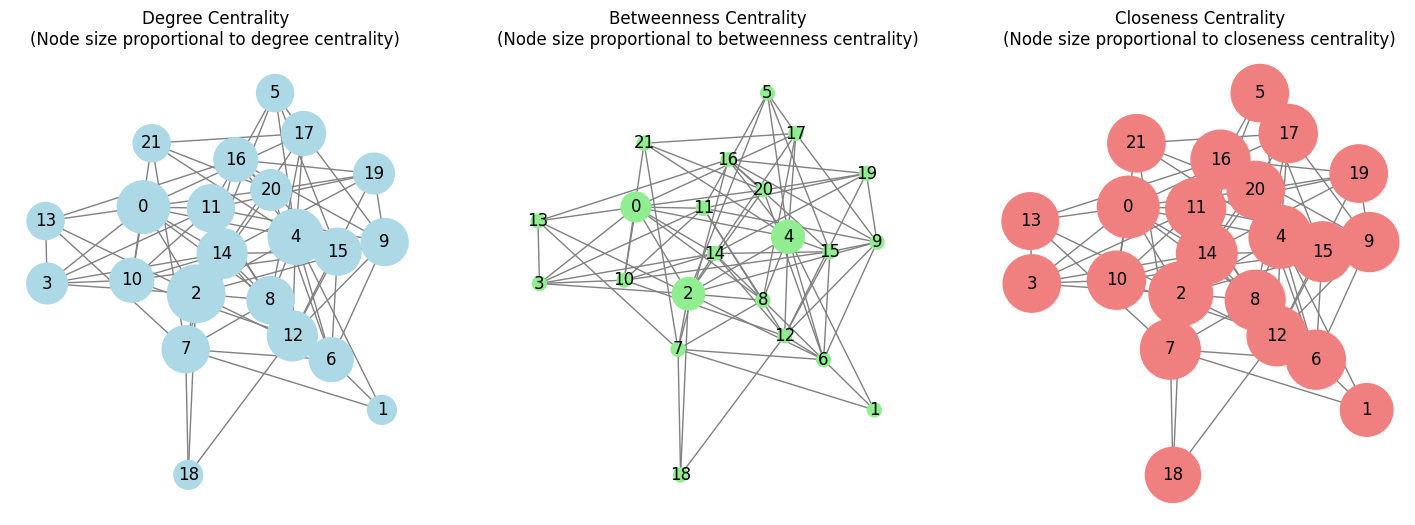

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Use same layout for all visualizations for easier comparison
pos = nx.spring_layout(G, seed=42)

# Visualization 1: Degree Centrality
# Scale node sizes based on degree centrality (multiply by 3000 for visibility)
node_sizes_degree = [degree_centrality[node] * 3000 for node in G.nodes()]
nx.draw(G, pos, node_size=node_sizes_degree, with_labels=True,
        node_color='lightblue', edge_color='gray', ax=axes[0])
axes[0].set_title("Degree Centrality\n(Node size proportional to degree centrality)", fontsize=12)

# Visualization 2: Betweenness Centrality
# Scale node sizes based on betweenness centrality
# Add a minimum size to make all nodes visible
node_sizes_betweenness = [max(betweenness_centrality[node] * 3000, 100) for node in G.nodes()]
nx.draw(G, pos, node_size=node_sizes_betweenness, with_labels=True,
        node_color='lightgreen', edge_color='gray', ax=axes[1])
axes[1].set_title("Betweenness Centrality\n(Node size proportional to betweenness centrality)", fontsize=12)

# Visualization 3: Closeness Centrality
# Scale node sizes based on closeness centrality
node_sizes_closeness = [closeness_centrality.get(node, 0.01) * 3000 for node in G.nodes()]
nx.draw(G, pos, node_size=node_sizes_closeness, with_labels=True,
        node_color='lightcoral', edge_color='gray', ax=axes[2])
axes[2].set_title("Closeness Centrality\n(Node size proportional to closeness centrality)", fontsize=12)



# Question 3

## Section A

In [ ]:
def check_balance(G):
    G_pos = nx.Graph()
    G_pos.add_nodes_from(G.nodes())
    for u, v, data in G.edges(data=True):
        label = data.get('label', '+')
        if label == '+':
            G_pos.add_edge(u, v)

    comp_id = {}
    for idx, comp in enumerate(nx.connected_components(G_pos)):
        for node in comp:
            comp_id[node] = idx

    for u, v, data in G.edges(data=True):
        label = data.get('label', '+')
        if label == '-':
            if comp_id[u] == comp_id[v]:
                return False

    H = nx.Graph()
    H.add_nodes_from(set(comp_id.values()))
    for u, v, data in G.edges(data=True):
        label = data.get('label', '+')
        if label == '-':
            cu, cv = comp_id[u], comp_id[v]
            if cu != cv:
                H.add_edge(cu, cv)

    if H.number_of_edges() == 0:
        return True

    return nx.is_bipartite(H)


## Sections C

In [ ]:
group1 = ["Rue", "Jules", "Fez"]
group2 = ["Nate", "Maddy", "Cassie"]

names = group1 + group2
N = len(names)

G = nx.complete_graph(N)

for u, v in G.edges():
    if u < len(group1) and v < len(group1):
        G[u][v]['label'] = '+'
    elif u >= len(group1) and v >= len(group1):
        G[u][v]['label'] = '+'
    else:
        G[u][v]['label'] = '-'

mapping = {i: names[i] for i in G.nodes()}
G = nx.relabel_nodes(G, mapping)



In [ ]:
def visualize(G):
    pos = nx.spring_layout(G, seed=1)

    # colors for edges based on label
    edge_colors = []
    for u, v in G.edges():
        if G[u][v]['label'] == '+':
            edge_colors.append('tab:green')
        else:
            edge_colors.append('tab:red')

    # draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=600)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # draw edges with colors
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

    # legend
    import matplotlib.lines as mlines
    pos_line = mlines.Line2D([], [], color='tab:green', label='Positive edge (+)')
    neg_line = mlines.Line2D([], [], color='tab:red', label='Negative edge (-)')
    plt.legend(handles=[pos_line, neg_line], loc='best')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

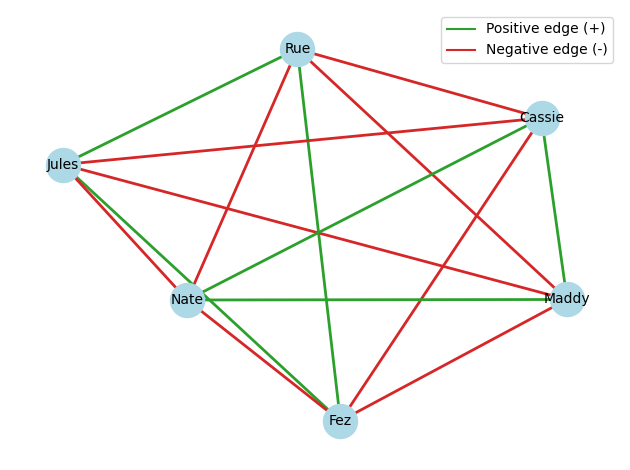

According to the algorithm in section A, is the graph balanced? True


In [ ]:
visualize(G)
print(f'According to the algorithm in section A, is the graph balanced? {check_balance(G)}')

## Section D

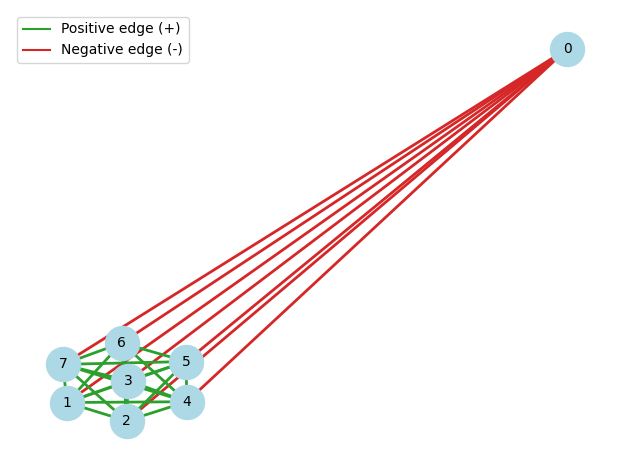

In [ ]:
N = 8
G = nx.complete_graph(N)

# Add signs
for u, v in G.edges():
    if 0 in (u, v):       # negative edges from node 0
        G[u][v]['weight'] = 0
        G[u][v]['label'] = '-'
    else:                 # positive edges inside the large coalition
        G[u][v]['weight'] = 1
        G[u][v]['label'] = '+'

# Add positions for visualization (REQUIRED)
pos = nx.spring_layout(G, seed=1)
nx.set_node_attributes(G, pos, 'pos')

# Visualize
visualize(G)

## Section E

There is no integer $N>3$ for which there exists a balanced signed complete graph on $N$ vertices that has three times more negative edges than positive edges.

**Proof:**  
Let $K_N$ be a complete graph with edges labeled “$+$” or “$-$”.  
Let $P$ be the number of “$+$” edges and $M$ the number of “$-$” edges.  
We assume the graph is balanced and satisfies the ratio condition  
$$M = 3P.$$

By the structural balance theorem, a complete signed graph is balanced if and only if either:

1. all edges are “$+$”, or  
2. the vertices can be partitioned into two nonempty groups $V_1, V_2$ such that all edges inside each group are “$+$” and all edges between the groups are “$-$".

We consider the two cases.

**Case 1:** All edges are “$+$”.  
Then $M = 0$ and the condition $M=3P$ would give $0 = 3P$, hence $P=0$,
but a completed graph of size $N>3$ cannot have zero edges so this case is impossible.

**Case 2:** Two-group structure.  
Let $|V_1| = a$, $|V_2| = b$, with $a,b \ge 1$ and $a+b=N$.  
Then
$$P = \binom{a}{2} + \binom{b}{2} = \frac{a(a-1)}{2} + \frac{b(b-1)}{2},$$
$$M = ab.$$
The condition $M = 3P$ becomes
$$ab = 3\left( \frac{a(a-1)}{2} + \frac{b(b-1)}{2} \right).$$

Introduce the notation $s = a+b = N$ and $p = ab$.  
We use
$$a^2 + b^2 = (a+b)^2 - 2ab = s^2 - 2p.$$

Then
\begin{align*}
P &= \frac{a(a-1) + b(b-1)}{2} \\
  &= \frac{a^2 + b^2 - (a+b)}{2} \\
  &= \frac{s^2 - 2p - s}{2}.
\end{align*}

Since $M = p$, the condition $M=3P$ becomes
$$p = 3 \cdot \frac{s^2 - 2p - s}{2}.$$

Multiplying by $2$:
$$2p = 3s^2 - 6p - 3s.$$
Rearranging:
$$8p = 3s^2 - 3s,$$
so
$$p = \frac{3}{8}s(s-1).$$

On the other hand, for any $a,b$ with fixed sum $s$, the product is maximized when $a=b$, giving the inequality
$$ab \le \frac{s^2}{4}.$$

Thus we must have
$$\frac{3}{8}s(s-1) \le \frac{s^2}{4}.$$

Multiply by $8$:
$$3s(s-1) \le 2s^2.$$

Expanding:
$$3s^2 - 3s \le 2s^2,$$
so
$$s^2 - 3s \le 0,$$
which gives
$$s(s-3) \le 0.$$

This inequality holds only for $0 \le s \le 3$.

But $s = N$ is the number of vertices, and the problem assumes $N>3$.  
Thus no solution is possible.

**Conclusion:**  
There is no balanced signed complete graph on $N>3$ vertices with three times more “$-$” edges than “$+$” edges.
